# A Sample Homework Project

This sample homework project will show you in a nutshell what your work for Encoding Music should look like. It follows the [Notebook Style Guide](https://github.com/RichardFreedman/music_style_guide/blob/main/M255_Notebook_Style_Guide.md) and [Music Style Guide](https://github.com/RichardFreedman/music_style_guide).  And it also demonstrates the key sections of every notebook submitted for a class assignment or project:

* The preliminaries:  Quarto YAML cell and code import statement
* The three main sections:  Motivation/Implementation/Interpretation
* The bibliography of sources consulted

### 0. Quarto YAML cell and Import Statement

The Quarto YAML cell will contain the title, name of author(s) and date for your assignment.

The Import Statement is just that:  the code cell where you import all relevant libraries for your work,

### 1. Motivation

What is your point of inquiry?  What are you trying discover?  What do you _expect_ to find? How do these questions relate to themes and problems considered in the course so far?  

What specific readings or musical repertories are involved, and why do they matter in this context (be sure to cite them, and to follow the Music Style Guide as you do so)?

### 2. Implementation

How did you put your query into practice? What did you need to do with or to your data along the way? 

* What _logical_ steps did you follow as you thought about getting there (expressed in pseudo code; perhaps in bullet-point form in your markdown cell)?
* Which tools (or methods) did you select, and why were they right for the job?
* If you chose to create some kind of visualization (a chart, network or map), how did you decide on the right representation for the task at hand?
* What challenges did you face as you worked to put the steps into action in code?  Did you need to clean or tidy your data?  Filter, sort, or group it in some way?
* What were the most important tools or approaches you deployed that others might like to know about?

Remember to use `verbatim code` or **block code** to show your work as needed.
Remember to add **comments** to your code to show the most important steps.

If you learned from or adapted some code suggested in Encoding Music, or another resource, it would be good to cite that documentation, too.

### 3. Interpretation

What did you learn from the results? How were your expectations confirmed (or not)?

What limitations did the data or your methods impose on your capacity to answer the questions you originally posed? 

How do your results change your views of the readings or ideas that motivated your work it the first place?  How do your results shape your listening experience of the music you considered? What next steps do you imagine for future work?

### 4. Bibliography

A list of the sources consulted and cited during your work, including class readings or code resources, Spotify lists, etc.  See the [Notebook Style Guide](https://github.com/RichardFreedman/music_style_guide/blob/main/M255_Notebook_Style_Guide.md) and [Music Style Guide](https://github.com/RichardFreedman/music_style_guide) for details about how to cite books, articles, internet resources, etc.


# 0. Import Libraries

Here I import the essential libraries for this assignment.

In [94]:
# import libraries
from community import community_louvain
from copy import deepcopy
from IPython.display import SVG
import altair as alt
import glob as glob
import numpy as np
import os
import pandas as pd
import re
import networkx as nx
import plotly.express as px
import requests

# setup plotting for quarto
alt.renderers.enable('default')
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

# supress warnings
import warnings
warnings.filterwarnings('ignore')


# 1. Motivation 

The Beatles are my favorite band, and I know that their music underwent rapid and profound change during the 1960s.  The albumns *Rubber Soul* (1965) and *Revolver* (1966) held pivotal places in this evolution, as Walter Everett explained in his excellent 1999 book, *The Beatles as Musicians:  Revolver to The Anthology*.  So I was interested to see whether this change was in any way evident in the kind of "music feature" data derived from the recordings themselves, in this case by Spotify.  

Can we see any trends across the Beatles output based on the sound itself?  Can we find any albumns that stand out from others?  And how would the evidence provided by Spotify's machine analysis tools align with my own impressions of the music, or Everett's?


# 2. Implementation

Prof. Freedman has conveniently assembled the Spotify data on all of the Beatles albumns as a single CSV file.  So this would be a simple starting place.  But since I am still a bit uncertain about the what Spotify's audio features are like, I thought the best first step would be to look at the columns in that data set and see which of them might be good candidates to tell me a bit more about the "range" of ratings for each.  If I am looking for change, then I need features (or combinations of features) that have the widest possibility for variation.

I looked at the columns as a list:  `beatles_spotify.columns`, which yielded (among the music feature categories) `['danceability', 'energy', 'speechiness','acousticness', 'liveness', 'valence']`.  Based on my exploration of the Spotify documentation and Nick Seaver's *Computing Taste Algorithms and the Makers of Music Recommendation*  I thought that 'danceability', 'energy', and 'acousticness' seemed the the categores most likely to reveal the trends I was interested in, particularly since (as I learned from Everett) the Beatles' recordings moved from a concert and dance music context to a contemplative, narrative and listening one. I guessed that I might see a decline in danceability over time and also a decline in acousticness (as more studio techniques came to the fore).

As explained in the code cells below, I broke this down into several exploratory steps:

2A.  I looked at the range of data for each audio feature, in this case by cutting the data for all tracks into 'bins' for each column using the Pandas 'cut' method.  There were some clear trends here, but since this was at the *track* level it was hard for me to say much about individual albumns over time.

2B.  Then I came up with ways of aggregating the data for each album using Pandas `groupby` operations.  These are a bit tricky to understand, but using this I was easily able to say something about each.  The key think with `groupby` is to remember that you need to pass in a *list* of the columns, and then specify the function to apply to each of them (in this case:  `mean`.  Resetting the index gets the year and album names back in the dataframe and makes the whole easier to parse in subsequent steps.  The complete code is:

```python
grouped_data = beatles_spotify.groupby(['year', "album"])[['danceability', 'energy', 'acousticness']].mean()
grouped_data = grouped_data.reset_index()
```

2C.  The resulting dataframe of results was hard for me to interpret, so I hit upon the idea of showing a kind of 'triple bar chart' for each album, with a consistent color for each feature. This was useful, since it allowed me to see what was distinctive about certain records as a whole.  *Rubber Soul* stood out on account of the *divergence* between the audio features (it hasd a much *lower* score for 'acousticness' in relation to the other features than any other album.

2D.  This in turn prompted me to make a scatterplot for this album on its own and then to test those results against my own impressions and those of my authors.

The commented code for each of these appears in the relevant cells below.








#### Getting the Data from the CSV

In [95]:
# the address of the shared CSV provided by Prof Freedman
beatles_spotify_csv = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRCv45ldJmq0isl2bvWok7AbD5C6JWA0Xf1tBqow5ngX7_ox8c2d846PnH9iLp_SikzgYmvdPHe9k7G/pub?output=csv'
# import that to a Pandas dataframe and name it
beatles_spotify = pd.read_csv(beatles_spotify_csv)


#### Checking the column names

In [96]:
# find the columns in the dataframe
beatles_spotify.columns

Index(['id', 'year', 'album', 'song', 'danceability', 'energy', 'speechiness',
       'acousticness', 'liveness', 'valence', 'duration_ms'],
      dtype='object')

#### Clean up NaNs for now

In [97]:

# some precautionary cleanup in case of NAs
beatles_spotify.fillna('').head()

,id,year,album,song,danceability,energy,speechiness,acousticness,liveness,valence,duration_ms
0,1,1963,Please Please Me,I Saw Her Standing There,0.491,0.801,0.0361,0.270,0.0665,0.971,173947
1,2,1963,Please Please Me,Misery,0.591,0.605,0.0413,0.707,0.3090,0.882,108547
2,3,1963,Please Please Me,Anna,0.608,0.565,0.0336,0.635,0.0601,0.835,177133
3,4,1963,Please Please Me,Chains,0.654,0.561,0.0304,0.608,0.1290,0.929,145080
4,5,1963,Please Please Me,Boys,0.402,0.860,0.0504,0.607,0.7360,0.822,146440


#### 2a: An informal way to review the range of values in each feature, over all albums

In [98]:
# and a very informal way to look at my columns to get a sense of the range of values across the albumns
# below I use the pandas "cut" method to split the data into 'bins' of similar values

# my preferred cols as a lis
column_list = ['danceability', 'energy', 'acousticness']
# a for loop
for col in column_list:
    # show the 'binned' values for each feature column
    print(pd.cut(beatles_spotify[col], bins=4).value_counts())

danceability
(0.513, 0.696]    93
(0.33, 0.513]     62
(0.145, 0.33]     19
(0.696, 0.88]     19
Name: count, dtype: int64
energy
(0.53, 0.749]     74
(0.31, 0.53]      67
(0.749, 0.969]    27
(0.0893, 0.31]    25
Name: count, dtype: int64
acousticness
(-0.000928, 0.243]    77
(0.243, 0.486]        47
(0.486, 0.728]        41
(0.728, 0.971]        28
Name: count, dtype: int64


#### 2b: Groupby operation using year/album, then the chosen audio features to find the mean values for each

In [99]:
grouped_data = beatles_spotify.groupby(['year', "album"])[['danceability', 'energy', 'acousticness']].mean()
grouped_data = grouped_data.reset_index()
grouped_data.style.set_caption("Table 1: Selected Mean Audio Feature Values for Beatles Albums").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '18px')
    ]
}])

,year,album,danceability,energy,acousticness
0,1963,Please Please Me,0.547929,0.599786,0.575500
1,1963,With The Beatles,0.500357,0.676143,0.417071
2,1964,A Hard Day's Night,0.601462,0.609538,0.377900
3,1964,Beatles for Sale,0.592286,0.596429,0.525000
4,1965,Help!,0.528000,0.610929,0.295386
5,1965,Rubber Soul,0.587786,0.539357,0.150806
6,1966,Revolver,0.482429,0.530571,0.406135
7,1967,Magical Mystery Tour,0.467727,0.486545,0.311273
8,1967,Sgt. Pepper's Lonely Hearts Club Band,0.515385,0.482538,0.298762
9,1968,The Beatles (white album),0.502567,0.503810,0.395290


#### 2c: A Plotly barchart to show the comparative values for each in a graphical way

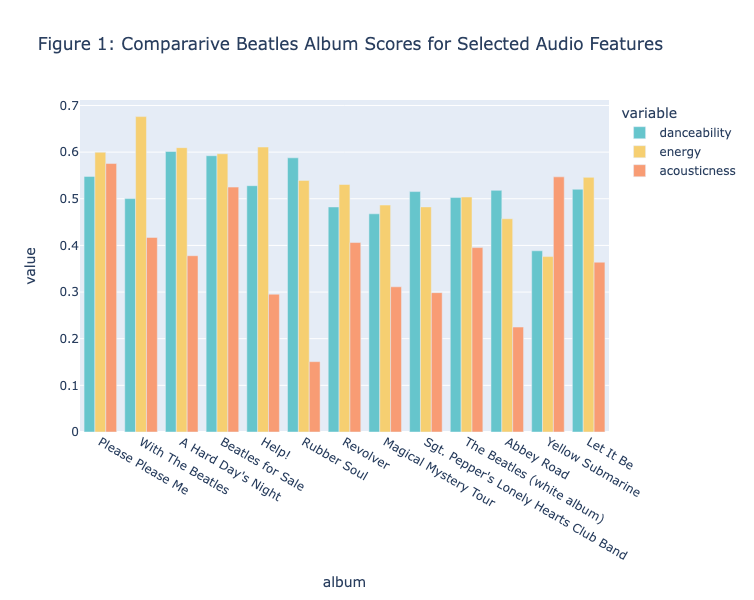

In [100]:
fig = px.bar(grouped_data,
             x='album',
             y=['danceability', 'energy', 'acousticness'],
             labels={'danceability': 'Danceability', 'energy': 'Energy', 'acousticness': 'Acousticness'},
             title='Figure 1: Compararive Beatles Album Scores for Selected Audio Features',
             color_discrete_sequence=px.colors.qualitative.Pastel)

# Update layout for better visualization
fig.update_layout(barmode='group', width=800, height=600)

# Show the figure
fig.show()

#### 2d:  Exploring Rubber Soul Features

In [101]:
# filtering full dataset for just this album
rubber_soul = beatles_spotify[beatles_spotify['album'] == 'Rubber Soul']
# create table and caption
rubber_soul.style.set_caption("Table 2: Rubber Soul Audio Features").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '18px')
    ]
}])

,id,year,album,song,danceability,energy,speechiness,acousticness,liveness,valence,duration_ms
69,70,1965,Rubber Soul,drive my car,0.754000,0.571000,0.042100,0.017300,0.300000,0.820000,148893
70,71,1965,Rubber Soul,norwegian wood,0.425000,0.369000,0.037900,0.183000,0.112000,0.650000,124693
71,72,1965,Rubber Soul,you wont see me,0.488000,0.539000,0.030400,0.136000,0.053800,0.473000,199960
72,73,1965,Rubber Soul,nowhere man,0.534000,0.624000,0.046200,0.007970,0.128000,0.687000,163693
73,74,1965,Rubber Soul,think for yourself,0.529000,0.567000,0.028200,0.012400,0.072900,0.799000,138520
74,75,1965,Rubber Soul,the word,0.590000,0.641000,0.041600,0.006820,0.055300,0.792000,163107
75,76,1965,Rubber Soul,michelle,0.578000,0.290000,0.034100,0.652000,0.105000,0.666000,162373
76,77,1965,Rubber Soul,what goes on,0.670000,0.776000,0.074900,0.016800,0.073200,0.765000,168573
77,78,1965,Rubber Soul,girl,0.699000,0.294000,0.029400,0.587000,0.117000,0.893000,151720
78,79,1965,Rubber Soul,im looking through you,0.667000,0.498000,0.036400,0.007720,0.048100,0.774000,146387


#### A Plotly Scatterplot for Rubber Soul

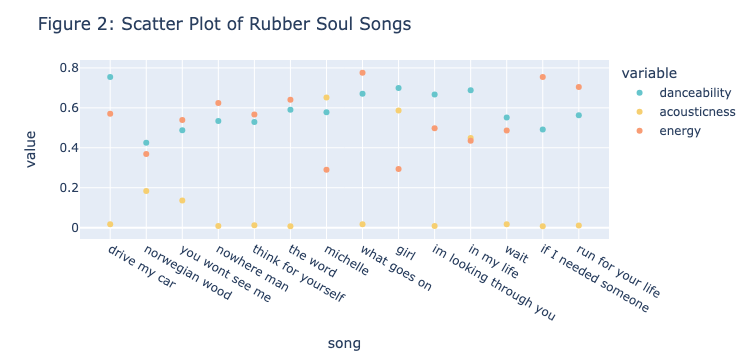

In [102]:
fig = px.scatter(rubber_soul, 
                 x='song', 
                 y=['danceability', 'acousticness', 'energy'], 
                 color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(title_text="Figure 2: Scatter Plot of Rubber Soul Songs")
fig.show()

# 3. Interpretation

I was both surprised by and curious to explore the results.  Based on the audio feature data I selected, *Rubber Soul* is clearly an outlier among the other album on account of the very wide gulf between the mean 'danceability and energy' on one hand and the 'acousticness' on the other.  Of course we cannot be completely how the Spotify assigns a single value to a track (much less the 'mean' scores that I derived from those individual pieces). But the *differential* is nevertheless striking.  What might it mean?

A low score in 'acousticness' might be another way of saying that these pieces are *more* electric, or at least more characterized by enriched timbres of the sort one could produce in the studio.  And indeed this is one of the important trends that marks the Beatles' development as musicians during this critical phase of their careers as a *studio* band.

So with this insight in mind, I decided to look more closely at the data for individual songs in *Rubber Soul* and test these against my own impressions of the music (and against what Everett said).  What is fascinating to me is that many of the songs that are characterized by Spotify as 'low' in acousticness still involve a good deal of very conventional instruments, voices, and even volume.  They are nevertheless filled with blended voices, and very diverse timbres (sitar, pseudo harpsichord, echo effects, and so on).  This is very interesting, and as Everett notes, reflects the increasing concern of the Beatles to use the studio itself as a kind of instrument, quite apart from the actual instruments and voices involved in the songs!



# 4.  Bibliography

Everett, Walter. 1999.  *The Beatles as Musicians: Revolver to The Anthology*.  Oxford and New York:  Oxford University Press.

Seaver, Nick. 2022.  *Computing Taste:  Algorithms and the Makers of Music Recommendation*.  Chicago:  University of Chicago Press.